# Time Series Model for Nonresidential Construction Spending Using Python
### David Lowe
### April 1, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. https://machinelearningmastery.com/

SUMMARY: The purpose of this project is to construct a time series prediction model and document the end-to-end steps using a template. The Nonresidential Construction Spending dataset is a time series situation where we are trying to forecast future outcomes based on past data points.

INTRODUCTION: The problem is to forecast the monthly total nonresidential construction spending in the United States. The dataset describes a time-series of miles (in millions of dollars) over a period of 18 years (2002-2020), and there are 217 observations. We used the first 80% of the observations for training various models while holding back the remaining observations for validating the final model.

ANALYSIS: The baseline prediction (or persistence) for the dataset resulted in an RMSE of 3,442. After performing a grid search for the most optimal ARIMA parameters, the final ARIMA non-seasonal order was (3, 1, 4) with the seasonal order being (2, 1, 2, 12). Furthermore, the chosen model processed the validation data with an RMSE of 1,029, which was better than the baseline model as expected.

CONCLUSION: For this dataset, the chosen ARIMA model achieved a satisfactory result and should be considered for further modeling.

Dataset Used: Total Construction Spending: Nonresidential

Dataset ML Model: Time series forecast with numerical attributes

Dataset Reference: https://fred.stlouisfed.org/series/TLNRESCON

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end
* Explore data cleaning and transformation options
* Explore various algorithms for baselining the model performance
* Explore tuning techniques for improving the model performance

A time series predictive modeling project genrally can be broken down into about five major tasks:

1. Define Problem and Acquire Data
2. Inspect and Explore Data
3. Clean and Pre-Process Data
4. Fit and Evaluate Models
5. Finalize Model

## Section 1. Define Problem and Acquire Data

### 1.a) Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib
import pmdarima as pm
import pandas_datareader.data as web
from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### 1.b) Set up the controlling parameters and functions

In [2]:
# Create the random seed number for reproducible results
seedNum = 888

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

In [3]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python ARIMA Time Series Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [4]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Acquire and Load the Data

Since the dataset is not current, this means that we cannot easily collect updated data to validate the model. Therefore, we will withhold a portion of the data towards the end from analysis and model selection. This very segment of data will be used to validate the final model.

In [5]:
startTimeScript = datetime.now()

In [6]:
# load the dataset and the necessary data structure
# time_series = pd.read_csv('https://dainesanalytics.com/datasets/time-series-data-library/tsdl200.csv', index_col='idx', parse_dates=True)

# Load the dataset from the Federal Reserve Bank's FRED Database
starting = datetime(2002, 1, 1)
ending = datetime.now()
fred_data = 'TLNRESCON'
time_series = web.DataReader(fred_data, 'fred', starting, ending)
time_series.rename(columns={fred_data: 'value'}, inplace=True)

# Sample code for subsetting the time-series data
# time_series = original_series['1986':'1990']

In [7]:
target_col = time_series.columns[0]
lower_bound = 'lower ' + target_col
upper_bound = 'upper ' + target_col
print('The target column of the time series is:', target_col)
print('The forecast boundary columns are:', lower_bound, '&', upper_bound)

The target column of the time series is: value
The forecast boundary columns are: lower value & upper value


In [8]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2002-01-01 to 2020-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   217 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [9]:
time_series.head(10)

,value
DATE,
2002-01-01,33545
2002-02-01,32868
2002-03-01,33956
2002-04-01,36496
2002-05-01,38325
2002-06-01,39273
2002-07-01,39983
2002-08-01,41101
2002-09-01,40460


In [10]:
time_series.tail(10)

,value
DATE,
2019-04-01,63878
2019-05-01,67828
2019-06-01,69885
2019-07-01,71292
2019-08-01,72324
2019-09-01,71853
2019-10-01,70953
2019-11-01,66869
2019-12-01,61670


In [11]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2. Inspect and Explore Data

In [12]:
if (notifyStatus): email_notify("Data Inspection and Exploration has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Summary Statistics of the Time Series Data

Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with.

In [13]:
# Summary statistics of time series
print(time_series.describe())

              value
count    217.000000
mean   50883.691244
std    10741.922669
min    30511.000000
25%    41995.000000
50%    50967.000000
75%    58919.000000
max    72324.000000


### 2.b) Line Plot of the Time Series Data

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:

* Whether the trend appears to be level around the mean
* Whether there appear to be any obvious outliers

The ARIMA(p,d,q) model requires three parameters and assumes that we are working with a stationary time series.

The ADF results should show that the test statistic value is smaller than the critical value at 5% if the time series is stationary. This suggests that we can reject the null hypothesis (i.e. a low probability that the result is a statistical fluke).

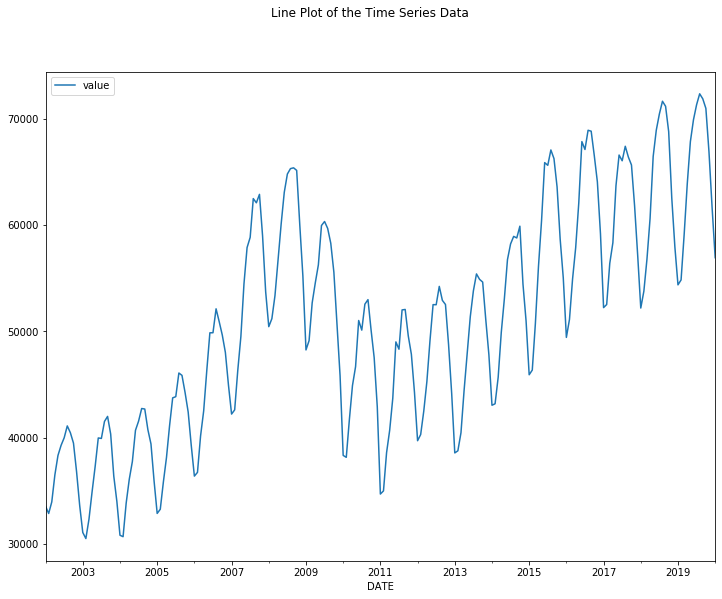

In [14]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Time Series Data')
time_series.plot(ax=ax)
plt.show()

### 2.c) Histogram and Density Plots of the Time Series Data

Reviewing plots of the density of observations can provide further insight into the structure of the data. Some observations from the plots can include:

* Whether the distribution is Gaussian
* Whether the distribution has a long tail and may suggest the need for data transformation

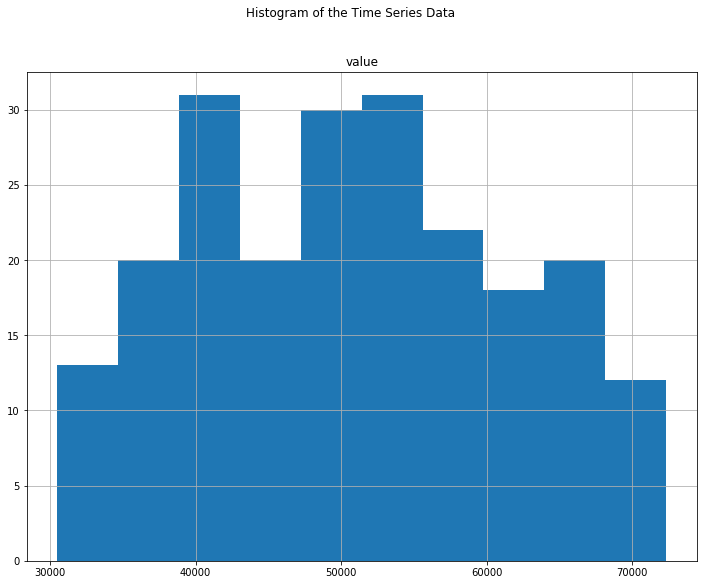

In [15]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Histogram of the Time Series Data')
time_series.hist(ax=ax)
plt.show()

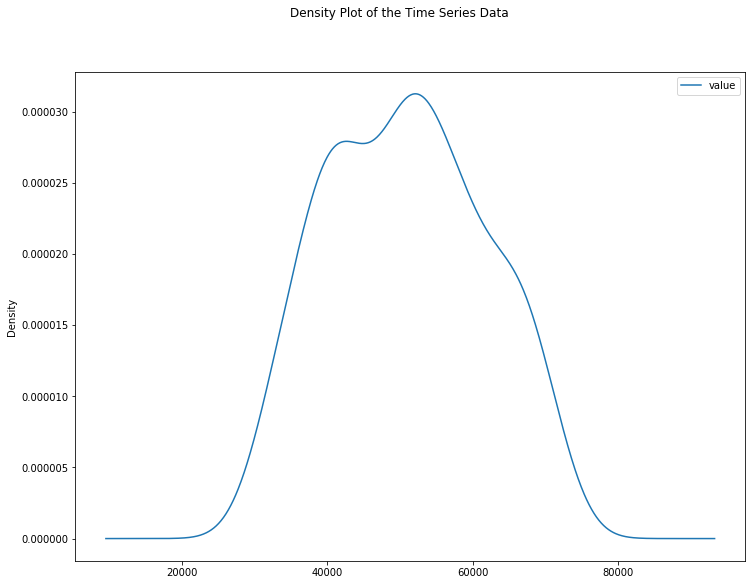

In [16]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Density Plot of the Time Series Data')
time_series.plot(kind='kde', ax=ax)
plt.show()

### 2.d) Box and Whisker Plots of the Time Series Data

We can group or aggregate the data and get a better idea of the spread of observations. Some observations from reviewing the plot can include:

* Whether the median values for each grouping shows any significant trend
* Whether the spread, or middle 50% of the data, shows any significant variability
* Whether there are outliers in some grouping

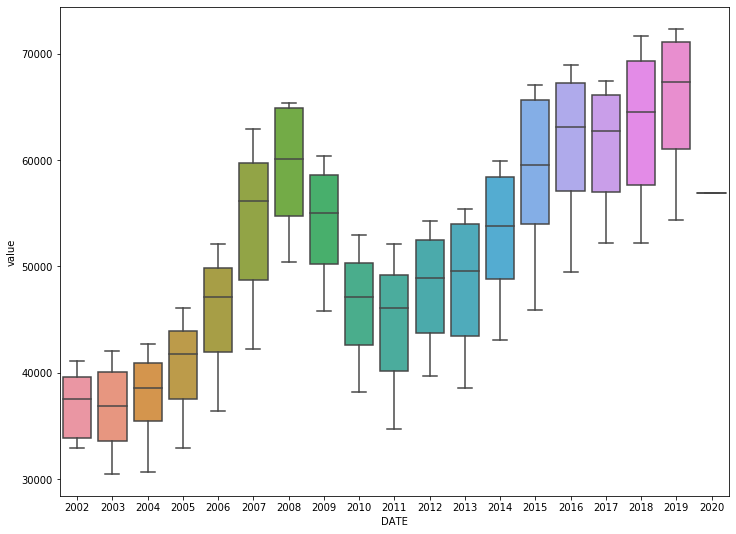

In [17]:
# boxplots of time series
fig, ax = plt.subplots(figsize=(12,9))
squeezed = time_series.squeeze()
sns.boxplot(squeezed.index.year, squeezed, ax=ax)
plt.show()

In [18]:
if (notifyStatus): email_notify("Data Inspection and Exploration completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3. Data Transformation and Stationarity Tests

In [19]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### Section 3.a) Data Transformation

In [20]:
# Resampling the time series into monthly average for the ease of modeling
# original_series = time_series
# resample = original_series.resample('M')
# time_series = resample.mean()
# time_series.head(10)

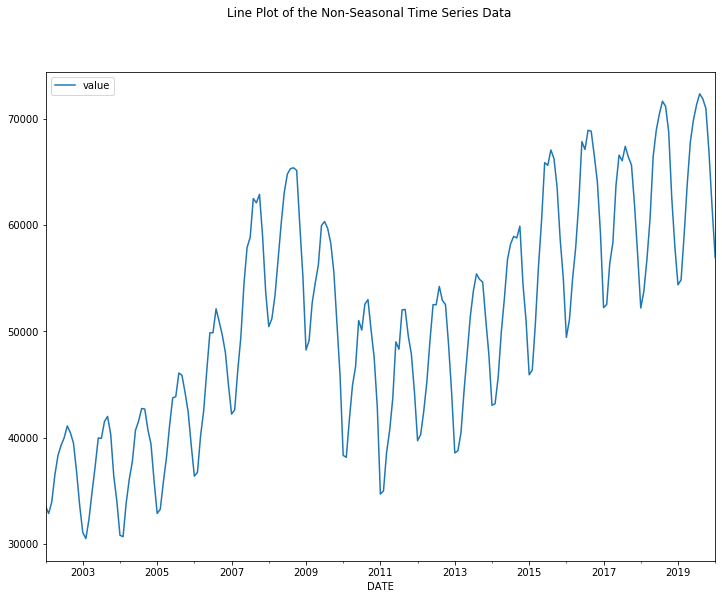

In [21]:
# Line plots of the transformed time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Non-Seasonal Time Series Data')
time_series.plot(ax=ax)
plt.show()

### Section 3.b) Test for Stationarity

In [22]:
# Check if stationary
result = adfuller(time_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.646538
p-value: 0.458847
Critical Test Statistics Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


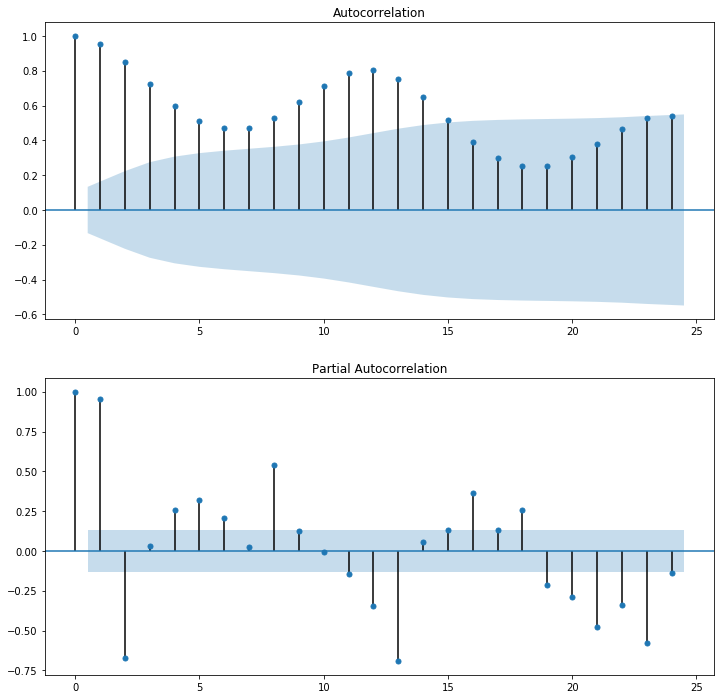

In [23]:
# ACF and PACF plots of the time series data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(time_series, ax=ax1)
plot_pacf(time_series, ax=ax2)
plt.show()

### 3.c) Test for Stationarity of Non-Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

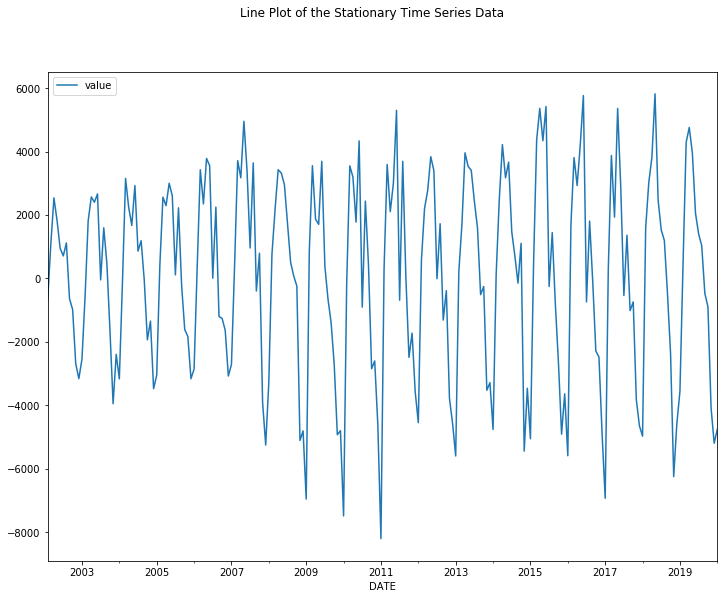

In [24]:
# Create a differenced series
stationary_ns = time_series.diff().dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Time Series Data')
stationary_ns.plot(ax=ax)
plt.show()

In [25]:
# Check for stationarity
result = adfuller(stationary_ns[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.618148
p-value: 0.089304
Critical Test Statistics Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


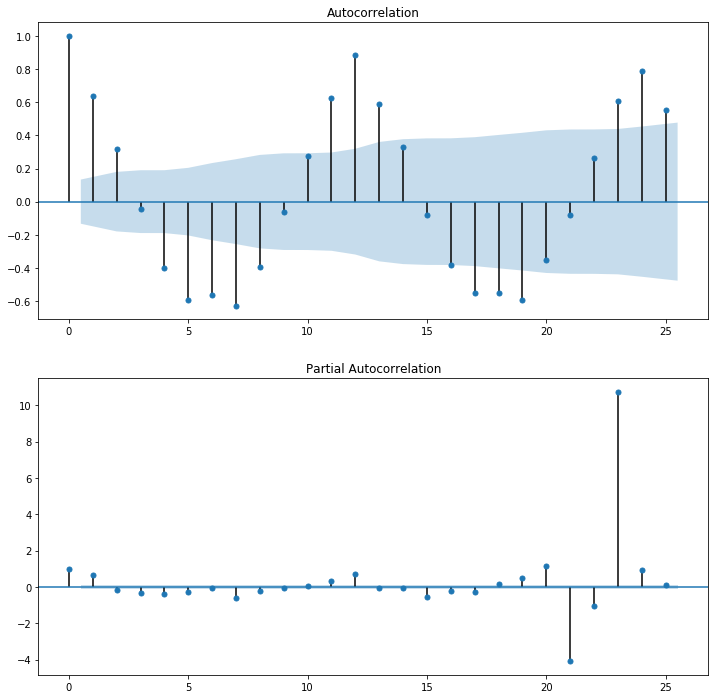

In [26]:
# ACF and PACF plots of the stationary time series
lags = 25
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ns, lags=lags, ax=ax1)
plot_pacf(stationary_ns, lags=lags, ax=ax2)
plt.show()

### 3.d) Seasonal Decomposition for Seasonal Time Series Data

In [27]:
# Set the initial seasonal frequency parameter
seasonal_freq = 12

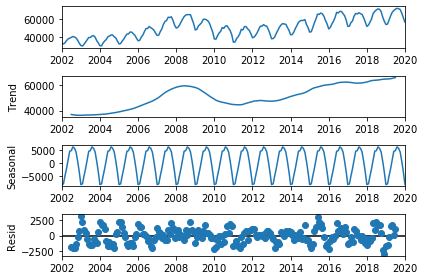

In [28]:
# Perform seasonal decomposition to observe the seasonal frequency
decomp_results = seasonal_decompose(time_series, period=seasonal_freq)
decomp_results.plot()
plt.show()

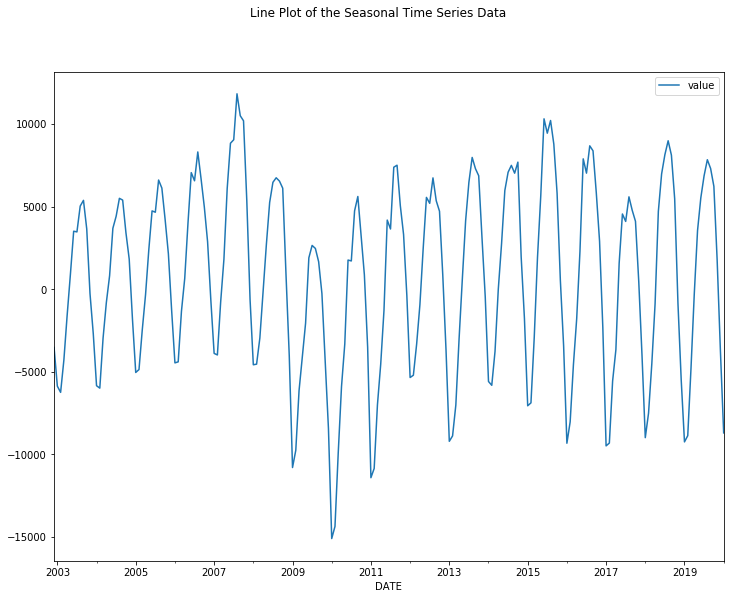

In [29]:
# Create a seasonal series
N = seasonal_freq
seasonal_series = time_series - time_series.rolling(N).mean()
seasonal_series = seasonal_series.dropna()

# Line plots of the seasonal time series
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Seasonal Time Series Data')
seasonal_series.plot(ax=ax)
plt.show()

In [30]:
# Check for stationarity
result = adfuller(seasonal_series[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.425051
p-value: 0.134790
Critical Test Statistics Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


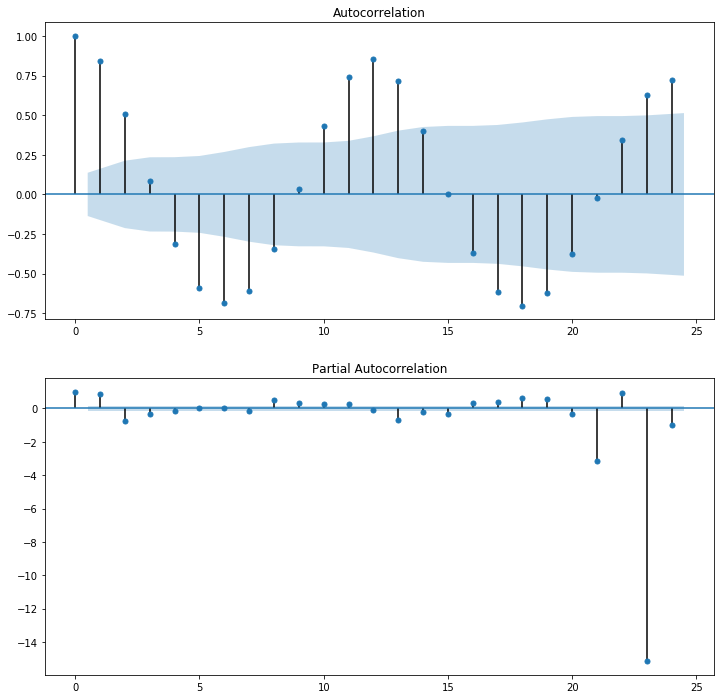

In [31]:
# ACF and PACF plots of the time series data
lag = seasonal_freq * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(seasonal_series, lags=lag, ax=ax1)
plot_pacf(seasonal_series, lags=lag, ax=ax2)
plt.show()

### 3.e) Test for Stationarity of Seasonal Time Series Data

Occasionally a time series may look non-stationary on the first look. We can make it stationary by differencing the series and using a statistical test to confirm that the differenced result is stationary. Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

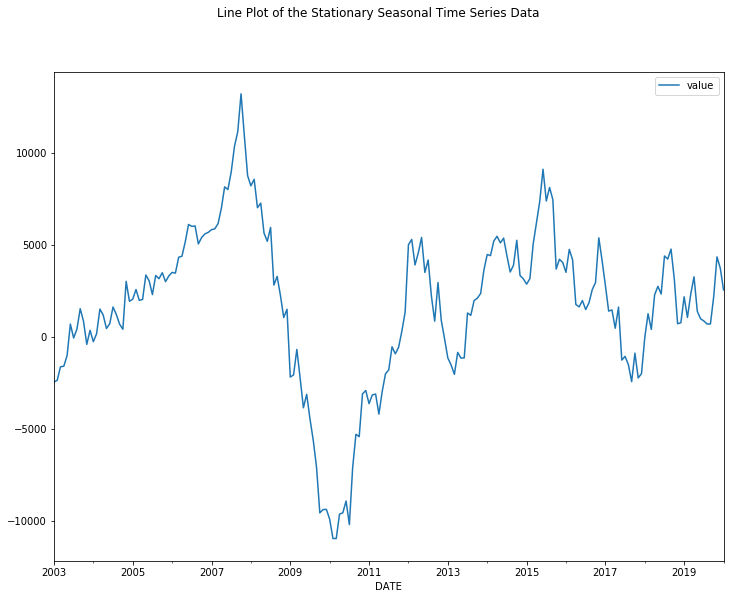

In [32]:
# Create a differenced series
stationary_ss = time_series.diff(seasonal_freq).dropna()

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
stationary_ss.plot(ax=ax)
plt.show()

In [33]:
# Check for stationarity
result = adfuller(stationary_ss[target_col])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.815792
p-value: 0.056053
Critical Test Statistics Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


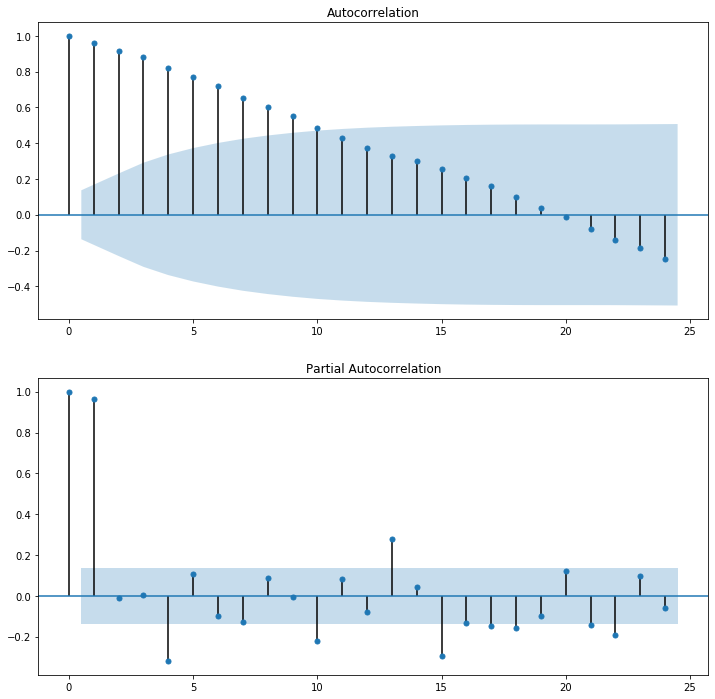

In [34]:
# ACF and PACF plots of the stationary time series
lags = seasonal_freq * 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
plot_acf(stationary_ss, lags=lags, ax=ax1)
plot_pacf(stationary_ss, lags=lags, ax=ax2)
plt.show()

In [35]:
if (notifyStatus): email_notify("Data Cleaning and Pre-Processing completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 4. Fit and Evaluate Models

In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models for the problem. We will first establish a persistent model. Next we will use a grid search approach to look for an optimal ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

* Establish the Persistent Model
* Automatically Configure the ARIMA
* Review Residual Errors

In [36]:
if (notifyStatus): email_notify("Model Fitting and Evaluation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Establish the Persistent Model

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance. This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence. This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

#### 4.a.iii) Establish the Persistent Model as Baseline

In [37]:
# Prepare and evaluate a persistence model
X = time_series.values
X = X.astype('float32')
train_pct = 0.80
train_size = int(len(X) * train_pct)
test_size = len(X) - train_size
train_ts, test_ts = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train_ts]
predictions = list()
for i in range(len(test_ts)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test_ts[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# Calculate performance
rmse = math.sqrt(mean_squared_error(test_ts, predictions))
print('RMSE for the persistent model is: %.3f' % rmse)

>Predicted=62063.000, Expected=67829
>Predicted=67829.000, Expected=67088
>Predicted=67088.000, Expected=68896
>Predicted=68896.000, Expected=68808
>Predicted=68808.000, Expected=66518
>Predicted=66518.000, Expected=64040
>Predicted=64040.000, Expected=59159
>Predicted=59159.000, Expected=52224
>Predicted=52224.000, Expected=52512
>Predicted=52512.000, Expected=56389
>Predicted=56389.000, Expected=58322
>Predicted=58322.000, Expected=63685
>Predicted=63685.000, Expected=66567
>Predicted=66567.000, Expected=66028
>Predicted=66028.000, Expected=67391
>Predicted=67391.000, Expected=66374
>Predicted=66374.000, Expected=65633
>Predicted=65633.000, Expected=61806
>Predicted=61806.000, Expected=57156
>Predicted=57156.000, Expected=52182
>Predicted=52182.000, Expected=53772
>Predicted=53772.000, Expected=56795
>Predicted=56795.000, Expected=60610
>Predicted=60610.000, Expected=66433
>Predicted=66433.000, Expected=68900
>Predicted=68900.000, Expected=70428
>Predicted=70428.000, Expected=71625
>

### 4.b) Grid Search of ARIMA Hyperparameters

We want to find a model that can do better than the persistence model on this dataset. To confirm this analysis, we can grid search a suite of ARIMA hyperparameters.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

In [38]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [39]:
# Set the initial P, D, and Q order parameters for non-seasonal ARIMA modeling
start_p = 0
start_d = None
start_q = 0
max_p = 4
max_d = 2
max_q = 4

In [40]:
# Set the initial P, D, and Q order parameters for seasonal ARIMA modeling
start_P = 0
start_D = None
start_Q = 0
max_P = 2
max_D = 1
max_Q = 2

In [41]:
# Testing the time series data for suggestions on the differencing term
start_d = pm.arima.ndiffs(train_ts)
print('The suggested non-seasonal differencing term is:', start_d)
if (seasonal_freq != 0):
    start_D = pm.arima.nsdiffs(train_ts, m = seasonal_freq)
    print('The suggested seasonal differencing term is:', start_D)

The suggested non-seasonal differencing term is: 1
The suggested seasonal differencing term is: 1


In [42]:
print('The initial non-seasonal parameters are: p =', start_p, '| d =', start_d, '| q =', start_q)
print('The maximum non-seasonal parameters are: max_p =', max_p, '| max_d =', max_d, '| max_q =', max_q)
if (seasonal_freq != 0):
    print('The initial seasonal parameters are: P =', start_P, '| D =', start_D, '| Q =', start_Q, '| m =', seasonal_freq)
    print('The maximum seasonal parameters are: max_P =', max_P, '| max_D =', max_D, '| max_Q =', max_Q)

The initial non-seasonal parameters are: p = 0 | d = 1 | q = 0
The maximum non-seasonal parameters are: max_p = 4 | max_d = 2 | max_q = 4
The initial seasonal parameters are: P = 0 | D = 1 | Q = 0 | m = 12
The maximum seasonal parameters are: max_P = 2 | max_D = 1 | max_Q = 2


In [43]:
# Do an automated stepwise search of ARIMA parameters
if (seasonal_freq == 0):
    stepwise_results = pm.auto_arima(train_ts, seasonal = False, stepwise = True, trace = True, suppress_warnings = True, random_state = seedNum)
else:
    stepwise_results = pm.auto_arima(train_ts, seasonal = True, m = seasonal_freq, stepwise = True, trace = True, suppress_warnings = True, random_state = seedNum)

Performing stepwise search to minimize aic
Fit ARIMA: (2, 0, 2)x(1, 1, 1, 12) (constant=True); AIC=3079.927, BIC=3104.578, Time=5.174 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=3185.701, BIC=3191.864, Time=0.047 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=2986.572, BIC=2998.898, Time=1.798 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=3063.736, BIC=3076.062, Time=1.665 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=3202.941, BIC=3206.022, Time=0.064 seconds
Fit ARIMA: (1, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=2995.627, BIC=3004.871, Time=0.530 seconds
Fit ARIMA: (1, 0, 0)x(2, 1, 0, 12) (constant=True); AIC=2988.294, BIC=3003.701, Time=4.238 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 1, 12) (constant=True); AIC=2997.564, BIC=3012.971, Time=3.541 seconds
Near non-invertible roots for order (1, 0, 0)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit A

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  173
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -1488.525
Date:                              Mon, 23 Mar 2020   AIC                           2985.049
Time:                                      22:01:55   BIC                           2997.375
Sample:                                           0   HQIC                          2990.054
                                              - 173                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    243.4366    216.038      1.127      0.260    -179.990     666.863
ar.L1          0.78

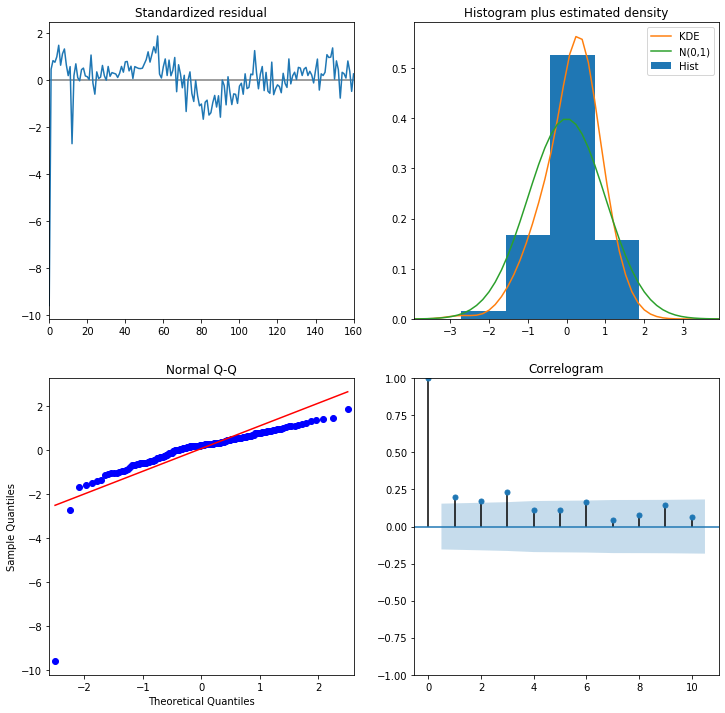

In [44]:
# Summarize residual errors for the automated grid search ARIMA model
print(stepwise_results.summary())
stepwise_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [45]:
if (notifyStatus): email_notify("ARIMA automated stepwise search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [46]:
# Do an automated random search of ARIMA parameters
n_fits = int(max_p * max_d * max_q * max_P * max_D * max_Q * 0.30)
if (seasonal_freq == 0):
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = False, stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)
else:
    randgrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
                                     seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
                                     stepwise = False, random = True, n_fits = n_fits, max_order = None,
                                     trace = True, suppress_warnings = True, random_state = seedNum)

Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=2726.373, BIC=2738.674, Time=0.486 seconds
Fit ARIMA: (2, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=2726.805, BIC=2745.256, Time=1.927 seconds
Fit ARIMA: (2, 1, 3)x(0, 1, 2, 12) (constant=True); AIC=2701.908, BIC=2729.585, Time=11.160 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 2, 12) (constant=True); AIC=2722.782, BIC=2741.233, Time=1.965 seconds
Fit ARIMA: (4, 1, 4)x(0, 1, 2, 12) (constant=True); AIC=2707.537, BIC=2744.439, Time=13.768 seconds
Fit ARIMA: (0, 1, 3)x(1, 1, 2, 12) (constant=True); AIC=2720.723, BIC=2745.324, Time=2.680 seconds
Fit ARIMA: (4, 1, 3)x(1, 1, 1, 12) (constant=True); AIC=2709.531, BIC=2743.358, Time=8.181 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=2723.479, BIC=2738.854, Time=2.895 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=2728.671, BIC=2744.047, Time=1.373 seconds
Fit ARIMA: (1, 1, 1)x(2, 1, 2, 12) (constant=True); AIC=2705.864, BIC=2730.465, Time=9.962 seconds
Fit ARIM

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  173
Model:             SARIMAX(3, 1, 4)x(2, 1, [1, 2], 12)   Log Likelihood               -1337.566
Date:                                 Mon, 23 Mar 2020   AIC                           2701.132
Time:                                         22:05:25   BIC                           2741.109
Sample:                                              0   HQIC                          2717.365
                                                 - 173                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1882     15.484      0.012      0.990     -30.159      30

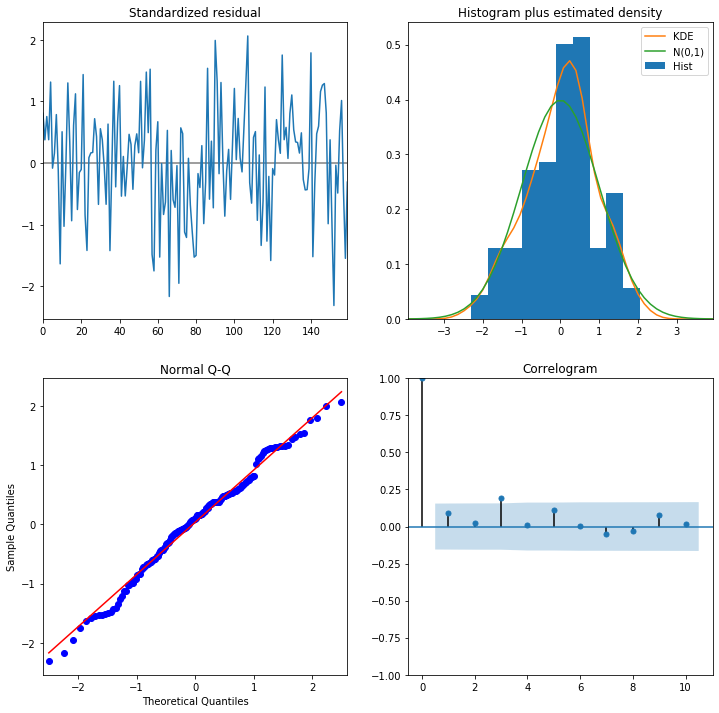

In [47]:
# Summarize residual errors for the automated grid search ARIMA model
print(randgrid_results.summary())
randgrid_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [48]:
if (notifyStatus): email_notify("ARIMA automated random search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
# Do an automated grid search of ARIMA parameters
# if (seasonal_freq == 0):
#     autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
#                                      seasonal = False, stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)
# else:
#     autogrid_results = pm.auto_arima(train_ts, start_p = start_p, d = start_d, start_q = start_q, max_p = max_p, max_d = max_d, max_q = max_q,
#                                      seasonal = True, m = seasonal_freq, start_P = start_P, D = start_D, start_Q = start_Q, max_P = max_P, max_D = max_D, max_Q = max_Q,
#                                      stepwise = False, max_order = None, trace = True, suppress_warnings = True, random_state = seedNum)

In [50]:
# Summarize residual errors for the automated grid search ARIMA model
# print(autogrid_results.summary())
# autogrid_results.plot_diagnostics(figsize=(12,12))
# plt.show()

In [51]:
if (notifyStatus): email_notify("ARIMA automated grid search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [52]:
# Not applicable for this iteration of the project

# Set up the function to handle the ARIMA calculation
# def Calculate_ARIMA(ns_order, ss_order):
#     startTimeModel = datetime.now()
#     aic_score, bic_score = float("inf"), float("inf")
#     if (verbose): print('Trying to fit the model with parameters:', ns_order, ss_order)
#     try:
#         if (ss_order[3] == 0): grid_model = SARIMAX(train_ts, order=ns_order)
#         else: grid_model = SARIMAX(train_ts, order=ns_order, seasonal_order=ss_order)
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             grid_results = grid_model.fit(disp = False)
#         aic_score = grid_results.aic
#         bic_score = grid_results.bic
#         if (verbose): print('Fit ARIMA: order=%s seasonal_order=%s; AIC=%.3f, BIC=%.3f, Fit time=%s' % 
#               (ns_order, ss_order, aic_score, bic_score, (datetime.now() - startTimeModel)))
#         return(aic_score, bic_score)
#     except:
#         return(float("inf"), float("inf"))

In [53]:
# Not applicable for this iteration of the project

# Do a manual grid search of ARIMA parameters
# best_score, best_ns_cfg, best_ss_cfg = float("inf"), None, None
# for p in range(start_p, max_p+1):
#     for d in range(start_d, max_d+1):
#         for q in range(start_q, max_q+1):
#             for P in range(start_P, max_P+1):
#                 for D in range(start_D, max_D+1):
#                     for Q in range(start_Q, max_Q+1):
#                         ns_order = (p, d, q)
#                         ss_order = (P, D, Q, seasonal_freq)
#                         aic_score, bic_score = Calculate_ARIMA(ns_order, ss_order)
#                         if (aic_score < best_score):
#                             best_ns_cfg, best_ss_cfg, best_score = ns_order, ss_order, aic_score
#                             print('A better model found: order=%s seasonal_order=%s; AIC=%.3f, BIC=%.3f' % (ns_order, ss_order, aic_score, bic_score))
# print('Best ARIMA model via manual search: order=%s seasonal_order=%s; AIC=%f' % (best_ns_cfg, best_ss_cfg, best_score))

In [54]:
# Summarize residual errors for the manual ARIMA model
# manual_model = SARIMAX(train_ts, order=best_ns_cfg, seasonal_order=best_ss_cfg)
# manual_results = manual_model.fit(disp = False)
# print(manual_results.summary())
# manual_results.plot_diagnostics(figsize=(12,12))
# plt.show()

In [55]:
if (notifyStatus): email_notify("ARIMA Hyperparameters Search completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.c) Evaluate the Residual Errors

A good final check of a model is to review residual forecast errors. Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

In [56]:
# Set the ARIMA order parameters for validation and forecasting
# final_ns_order = stepwise_results.order
final_ns_order = randgrid_results.order
# final_ns_order = autogrid_results.order
# final_ns_order = best_ns_cfg
if (seasonal_freq != 0):
#     final_ss_order = stepwise_results.seasonal_order
    final_ss_order = randgrid_results.seasonal_order
#     final_ss_order = autogrid_results.seasonal_order
#     final_ss_order = best_ss_cfg
    print("Final Non-season order:", final_ns_order, 'Final Seasonal Order:', final_ss_order)
else:
    print("Final Non-season order:", final_ns_order)

Final Non-season order: (3, 1, 4) Final Seasonal Order: (2, 1, 2, 12)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                        SARIMAX Results                                        
Dep. Variable:                                   value   No. Observations:                  217
Model:             SARIMAX(3, 1, 4)x(2, 1, [1, 2], 12)   Log Likelihood               -1706.942
Date:                                 Mon, 23 Mar 2020   AIC                           3437.884
Time:                                         22:05:45   BIC                           3477.702
Sample:                                     01-01-2002   HQIC                          3453.991
                                          - 01-01-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2307      0.855     -0.270      0.787      -1.906       1

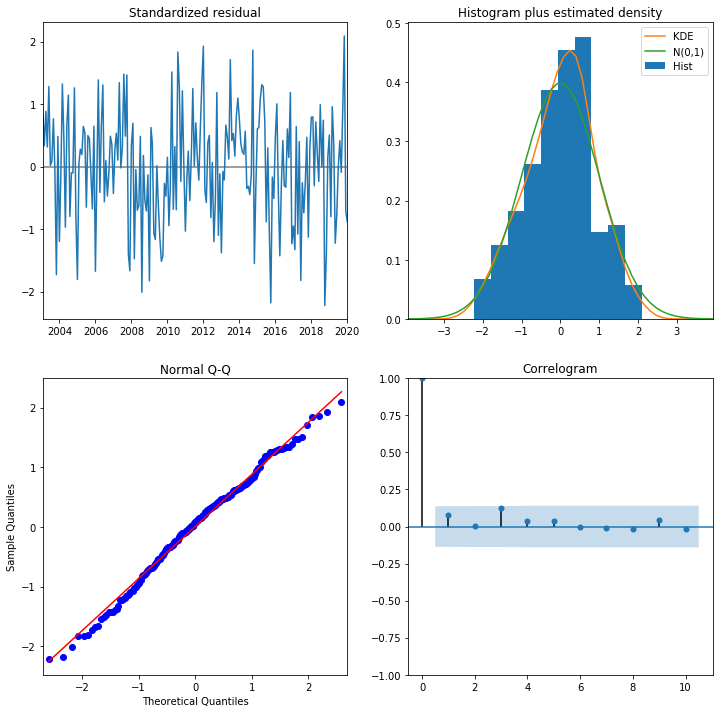

In [57]:
# Summarize residual errors for the final ARIMA model
if (seasonal_freq != 0):
    final_model = SARIMAX(time_series, order=final_ns_order, seasonal_order=final_ss_order)
else:
    final_model = SARIMAX(time_series, order=final_ns_order)
final_results = final_model.fit(disp = False)
print(final_results.summary())
final_results.plot_diagnostics(figsize=(12,12))
plt.show()

In [58]:
if (notifyStatus): email_notify("Model Fitting and Evaluation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 5. Finalize Model

After models have been developed and a final model selected, it must be validated and finalized. Validation is an optional part of the process, but one that provides a ‘last check’ to ensure we have not fooled or lied to ourselves.

In [59]:
if (notifyStatus): email_notify("Model Finalization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Validation via In-sample Data

In [60]:
validate_forecast = final_results.get_prediction(start = -test_size)
mean_validate_forecast = validate_forecast.predicted_mean
validate_confidence_intervals = validate_forecast.conf_int()

In [61]:
# Occasionally some predicted values turned out to be < 0 but they should not be (e.g. rainfall, disease cases, etc.)
# If we have those values, we will need to set them to 0
# print(mean_validate_forecast[mean_validate_forecast < 0])
# mean_validate_forecast[mean_validate_forecast < 0] = 0

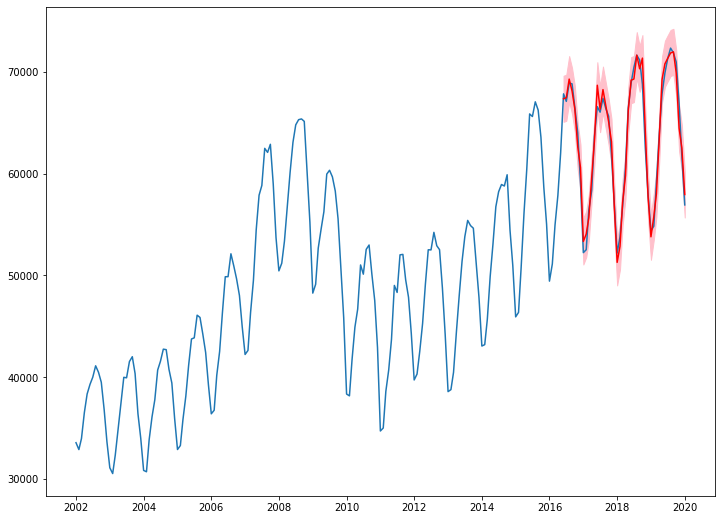

In [62]:
plt.figure(figsize=(12,9))
plt.plot(time_series.index, time_series[target_col], label='observed')
plt.plot(mean_validate_forecast.index, mean_validate_forecast.values, color='red', label='forecast')
plt.fill_between(validate_confidence_intervals.index, validate_confidence_intervals[lower_bound], 
                 validate_confidence_intervals[upper_bound], color='pink')
plt.show()

In [63]:
# Evaluate RMSE for the validation data
y_test = time_series[-test_size:]
predictions = mean_validate_forecast.values
for i in range(y_test.shape[0]):
    print(y_test.index[i], ' | ', y_test.iloc[i,0], ' | ', predictions[i])
print('RMSE from the validation data is: %.3f' % math.sqrt(mean_squared_error(y_test, predictions)))

2016-06-01 00:00:00  |  67829  |  67345.73657251822
2016-07-01 00:00:00  |  67088  |  67441.63347470337
2016-08-01 00:00:00  |  68896  |  69277.90513396602
2016-09-01 00:00:00  |  68808  |  68110.33927908927
2016-10-01 00:00:00  |  66518  |  66349.47493739342
2016-11-01 00:00:00  |  64040  |  62665.88901341745
2016-12-01 00:00:00  |  59159  |  60586.4282206518
2017-01-01 00:00:00  |  52224  |  53323.64929147642
2017-02-01 00:00:00  |  52512  |  54048.62967839519
2017-03-01 00:00:00  |  56389  |  55646.29734639231
2017-04-01 00:00:00  |  58322  |  59569.18641664199
2017-05-01 00:00:00  |  63685  |  63222.33367831602
2017-06-01 00:00:00  |  66567  |  68673.67183937463
2017-07-01 00:00:00  |  66028  |  66324.99347407954
2017-08-01 00:00:00  |  67391  |  68245.49422221236
2017-09-01 00:00:00  |  66374  |  66642.58661983407
2017-10-01 00:00:00  |  65633  |  65089.745630175086
2017-11-01 00:00:00  |  61806  |  63110.3803119344
2017-12-01 00:00:00  |  57156  |  56841.440049430115
2018-01-01 0

### 5.b) Forecasting Out-of-Sample Data

In [64]:
if (seasonal_freq != 0):
    forecast_size = seasonal_freq
else:
    forecast_size = 1
final_forecast = final_results.get_forecast(steps = forecast_size)
mean_final_forecast = final_forecast.predicted_mean
final_confidence_intervals = final_forecast.conf_int()
print("The forecasted values are:\n\n", mean_final_forecast)

The forecasted values are:

 2020-02-01    57216.775928
2020-03-01    61887.661045
2020-04-01    66199.512251
2020-05-01    70006.302191
2020-06-01    72835.049572
2020-07-01    73569.017036
2020-08-01    74205.541633
2020-09-01    74040.217991
2020-10-01    72456.192113
2020-11-01    68037.775359
2020-12-01    62990.682747
2021-01-01    57681.991521
Freq: MS, dtype: float64


In [65]:
# Occasionally some predicted values turned out to be < 0 but they should not be (e.g. rainfall, disease cases, etc.)
# If we have those values, we will need to set them to 0
# print(mean_final_forecast[mean_final_forecast < 0])
# mean_final_forecast[mean_final_forecast < 0] = 0

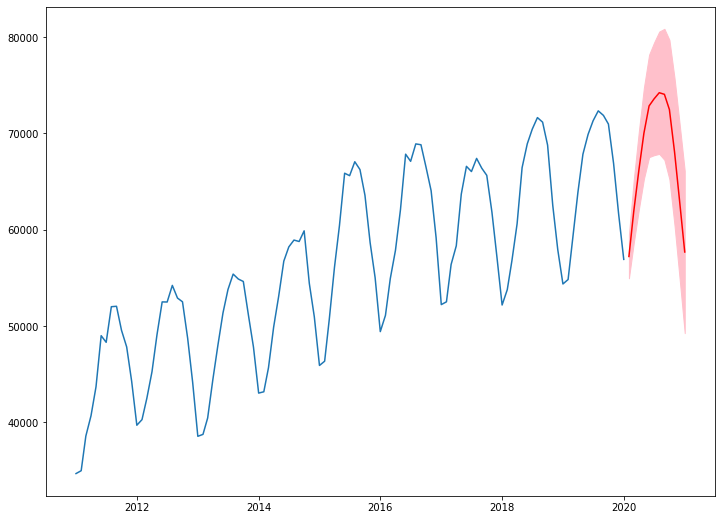

In [66]:
plt.figure(figsize=(12,9))
halfway_point = int(time_series.index.size / 2)
plt.plot(time_series.index[halfway_point:], time_series[target_col][halfway_point:], label='observed')
plt.plot(mean_final_forecast.index, mean_final_forecast.values, color='red', label='forecast')
plt.fill_between(final_confidence_intervals.index, final_confidence_intervals[lower_bound], 
                 final_confidence_intervals[upper_bound], color='pink')
plt.show()

In [67]:
if (notifyStatus): email_notify("Model Finalization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [68]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:04:49.069886
